# MeterReader - The Predicter

This notebok tests the prediction using the models trained by "trainer.ipynb"

- Frames : Get Extract the Frame inside of the meter from the original image
- Counter : Extract the Counter from within the frame
- Digits: Get the value of each digit of the Counter

## Training Data

The training data is taken from the respective Roboflow projects. The data is annotated using either Roboflow or manually via script (Digits)

## Models

The are pre-trained custom models, trained by the "trainer.ipynb script

## Process
The detation of the value of the electricity meter is done using three different model, to simplify the detection (each model is small enough to allow three t be loaded at the same time). This simplifies the algorithm, as there is hardly any image manipulation required. Inspriration comes from (OpenCV practice: OCR for the electricity meter)[https://en.kompf.de/cplus/emeocv.html]. However, the use of OCR did not give the expected results.

The idea here is to "divide and conquer". I.e. to desect the image in three simple steps, where each step will isolate a part of the image. Each part is big enough so the model will be simple and quick.



## Setup

Import the libraries and load the pretrained models used to   predict the meter values

Note: The training was done on a MacMini (2024) with a M4 Processor



In [1]:
# Uses the Ultralytics YOLOv11 Libraries
from ultralytics import YOLO
import torch

from  predict_helpers import *

# Check to see if running on a Mac or not (Apple Silicon)
device_to_use = 'cpu'

if torch.backends.mps.is_available():
    device_to_use = 'mps' # Apple Silicon

print(f"Device used for training: {device_to_use}")

# Load the three different models

project_name="meterreader_YOLO"

run_name_frame = "meter-frame-1"
run_name_counter= "meter-counter-640-1"
run_name_digits = "meter-digits-3"

model_path_digits = f"{project_name}/{run_name_digits}/weights/best.pt"
model_path_frame = f"{project_name}/{run_name_frame}/weights/best.pt"
model_path_counter= f"{project_name}/{run_name_counter}/weights/best.pt"

# load the models
model_frame = YOLO(model_path_frame) # Detect the main white frame of the electricity meter
model_counter = YOLO(model_path_counter) # Detect the counter frame on the image
model_digits = YOLO(model_path_digits) # Detect the value of the counter (the digits)





Device used for training: mps


## The Detection 

### The Frame


1. Extract the Frame from the image 



In [2]:
# Only needed if running inside a Jupyter Notebook
if is_running_in_jupyter():
    from ipyfilechooser import FileChooser
    # Create and display a FileChooser widget to select the file to process
    fc = FileChooser('/Users/yonz/Workspace/images')
    display(fc)


FileChooser(path='/Users/yonz/Workspace/images', filename='', title='', show_hidden=False, select_desc='Select…

Image /Users/yonz/Workspace/images/meter-frame-1/IMG_6981.jpg Shape = (5712, 3213) Image Dtype is: uint8


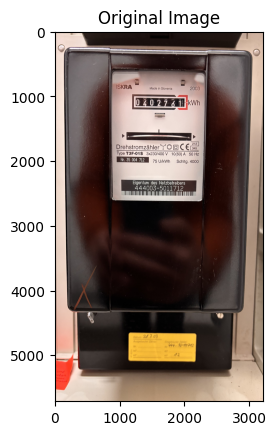

Loading model weights from: meterreader_YOLO/meter-frame-1/weights/best.pt

0: 576x320 1 meter-frames, 132.2ms
Speed: 4.8ms preprocess, 132.2ms inference, 48.5ms postprocess per image at shape (1, 3, 576, 320)


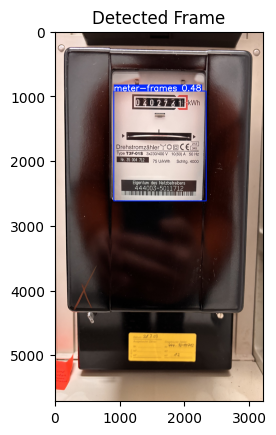

Frame Image Shape: (1696, 1426, 3)


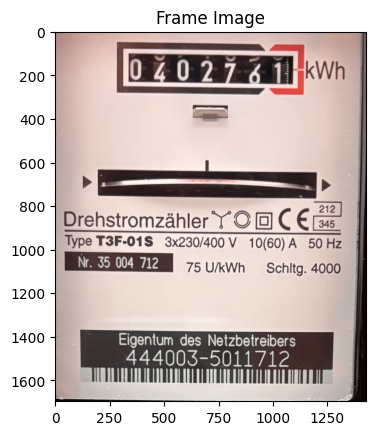

In [3]:
# Here  the image_path should be passed as an attribute to a class method / function
#
if  is_running_in_jupyter() and len(fc.selected) > 0:
    image_path = fc.selected
else:
    image_path = "/Users/yonz/Workspace/images/meter-frame-1/IMG_6987.jpg" 
    
image = load_image(image_path)
image_size = image.shape[:2]
print(f"Image {image_path} Shape = {image_size} Image Dtype is: {image.dtype}")
plot_image(image,title="Original Image", bgr=True)
print(f"Loading model weights from: {model_path_frame}")

# run first prediction on the image to get theframe with the counter
results = model_frame(image, device=device_to_use, imgsz=[640,320], conf=0.4, iou=0.5,
                        save=False, save_crop =False, save_txt=False,
                        name=f"{run_name_frame}/", project=f"{project_name}", exist_ok=True)


frame_image = None # initialize to None to indicate no detection
if results[0].boxes is not None and len(results[0].boxes.xyxy) > 0:
    boxes = results[0].boxes.xyxy  # Get the boxes directly
    box = boxes[0] # Take the first box, as we expect only one
    x1, y1, x2, y2 = map(int, box.tolist())
    frame_image = image[y1:y2, x1:x2].copy()
    plot_image(results[0].plot(), title="Detected Frame", bgr=True)

if frame_image is not None:
    # Process the cropped image
    print(f"Frame Image Shape: {frame_image.shape}")
    plot_image(frame_image, title="Frame Image", bgr=True)


else:
    print("No object detected in the image.")

# This functon should return the results image (with the bounding boxes), and the cropped  image counter detected
# return results[0].plot(), frame_image  

### The Counter


2. Extract the counter from the frame




0: 320x288 1 counters-aonJ, 132.6ms
Speed: 2.8ms preprocess, 132.6ms inference, 95.9ms postprocess per image at shape (1, 3, 320, 288)
Results saved to meterreader_YOLO/meter-counter-640-1


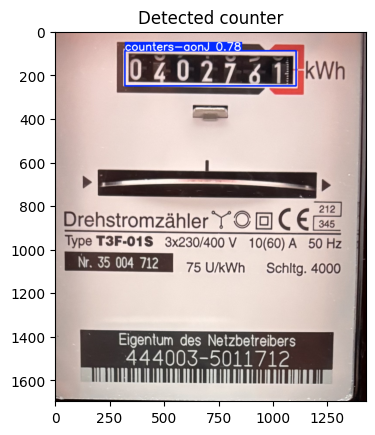

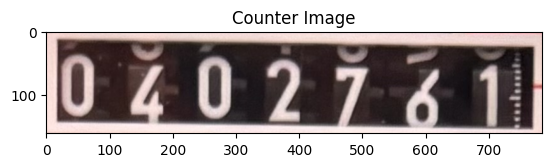

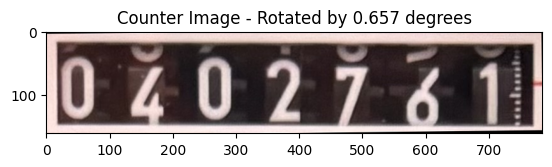

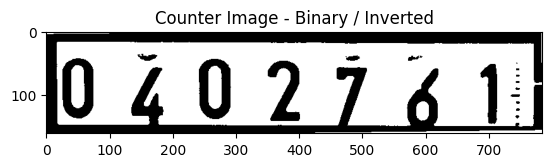

In [4]:
# Here the the crop area returned by previous function, should be passed as an attribute to a class method / function 

# run second prediction on the frame image to get counter itself
results = model_counter(frame_image, device=device_to_use, imgsz=[320,320], conf=0.4, iou=0.5,
                        save=False, save_crop =True, save_txt=False,
                        name=f"{run_name_counter}/", project=f"{project_name}", exist_ok=True)


counter_image = None # initialize to None to indicate no detection
if results[0].boxes is not None and len(results[0].boxes.xyxy) > 0:
    boxes = results[0].boxes.xyxy  # Get the boxes directly
    box = boxes[0] # Take the first box, as we expect only one
    x1, y1, x2, y2 = map(int, box.tolist())
    counter_image = frame_image[y1:y2, x1:x2].copy()
    plot_image(results[0].plot(), title="Detected counter", bgr=True)


if counter_image is not None:
    # Process the cropped image
    plot_image(counter_image, title="Counter Image", bgr=True)

    # Attemt to rotate the image so that the horizontal lines are straight,
    # then padd that image to a fixed site, for use in a second model
    rotation_angle = determine_rotation_angle(counter_image, horizontal_threshold=0.1)          
    image_rotated = rotate_image(counter_image, rotation_angle)
    plot_image(image_rotated, title=f"Counter Image - Rotated by {rotation_angle:.3f} degrees", bgr=True)
    
    # Convert the image to a simply binary (B/W) Image
    binary_image = convert_to_binary(image_rotated, bgr=True, invert=True)
    plot_image(binary_image, title="Counter Image - Binary / Inverted")
else:
    print("No object detected in the image.")

# This functon should return the results image (with the bounding boxes), and the cropped binary image
# return results[0].plot(), binary_image  


### The Digits

3. Extract the digits from the counter




0: 192x800 1 four, 1 one, 1 seven, 1 six, 1 three, 1 two, 2 zeros, 6.1ms
Speed: 3.4ms preprocess, 6.1ms inference, 79.6ms postprocess per image at shape (1, 3, 192, 800)
Results saved to meterreader_YOLO/meter-digits-3
2 labels saved to meterreader_YOLO/meter-digits-3/labels


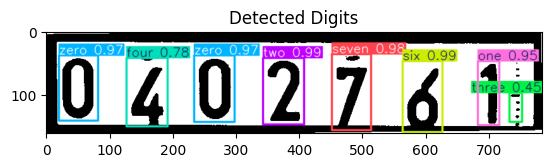

Valid box label: #1 (x1=20): zero -> 0
Valid box label: #2 (x1=127): four -> 4
Valid box label: #3 (x1=234): zero -> 0
Valid box label: #4 (x1=343): two -> 2
Valid box label: #5 (x1=452): seven -> 7
Valid box label: #6 (x1=564): six -> 6
Meter Value (str): 040276
Meter Value (int): 40276


In [5]:
# Here the the binary image genrated by previous function, should be passed as an attribute to a class method / function 

# Digit name to value mapping
digit_name_map = {
    "zero": "0",
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9",
    "ten": "10", # if needed
    "NaN": "NaN"
}

meter_value_str = ""
meter_value_int = None

results = model_digits(binary_image, device=device_to_use,  imgsz=[192,800], conf=0.4, iou=0.5,
                    save=True, save_crop =True, save_txt=True,
                    name=f"{run_name_digits}/", project=f"{project_name}", exist_ok=True)


if results[0].boxes is not None and len(results[0].boxes.xyxy) > 0:
    plot_image(results[0].plot(), title="Detected Digits", bgr=True)
    boxes = results[0].boxes.xyxy.tolist()  # Convert to list for easier iteration
    class_ids = results[0].boxes.cls.tolist()
    names = results[0].names

    valid_boxes = []

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        w = x2 - x1
        h = y2 - y1
        area = w * h

        if h > w and area >= 200:
            valid_boxes.append((i,x1, y1, x2, y2))
            # print(f"Valid Box found: Class {names[int(class_ids[i])]}, x1={x1}, y1={y1}, x2={x2}, y2={y2}, w={w}, h={h}, area={area}")
    
    if valid_boxes:
        # Sort valid boxes by x1 (reading order)
        valid_boxes.sort(key=lambda box: box[1])  # Sort by the second element (x1)

        num_digits_to_read = min(6, len(valid_boxes))
        for digitNo in range(num_digits_to_read):
            i, x1, y1, x2, y2 = valid_boxes[digitNo]
            digit_name = names[int(class_ids[i])]
            digit_value = digit_name_map.get(digit_name) # Get the digit value from the map
            if digit_value is not None:
                meter_value_str += digit_value
                print(f"Valid box label: #{digitNo+1} (x1={x1}): {digit_name} -> {digit_value}")
            else:
                print(f"Warning: Digit name '{digit_name}' not found in lookup table.")
                meter_value_str = None # Reset meter value since a digit could not be identified.
                break # Stop processing since the meter value is now invalid

        if meter_value_str is not None: # Only convert to int if all digits could be identified.
            print(f"Meter Value (str): {meter_value_str}")
            try:
                meter_value_int = int(meter_value_str)
                print(f"Meter Value (int): {meter_value_int}")
            except ValueError:
                print(f"Could not convert Meter Value ({meter_value_str}) to int")


    else:
        print("No valid boxes found matching the criteria.")
else:
    print("No digits detected.")


# This functon should return the results image (with the bounding boxes), the string and the int values
# return results[0].plot(), meter_value_str, meter_value_int